# **客户流失预测**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

## 1. 加载数据

In [3]:
# 1. 数据加载
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_noLabel.csv')

查看数据信息

In [4]:
train_data.head()

,ID,Contract,Dependents,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,Partner,PaymentMethod,PhoneService,SeniorCitizen,TVProgram,TotalCharges,gender,tenure,Label
0,0,One year,No,No internet service,No,24.150000,Yes,Yes,Bank transfer (automatic),Yes,0,No internet service,1505.900000,Male,60,No
1,1,Month-to-month,No,No,Fiber optic,76.142284,Yes,No,Electronic check,Yes,0,No,946.581518,Female,12,Yes
2,2,Month-to-month,Yes,No internet service,No,26.200000,Yes,Yes,Electronic check,Yes,0,No internet service,1077.500000,Female,40,No
3,3,Two year,Yes,No internet service,No,24.650000,Yes,Yes,Bank transfer (automatic),Yes,0,No internet service,1138.800000,Female,45,No
4,4,Month-to-month,Yes,No internet service,No,19.150000,No,Yes,Mailed check,Yes,0,No internet service,477.600000,Male,25,No


In [5]:
test_data.head()

,ID,Contract,Dependents,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,Partner,PaymentMethod,PhoneService,SeniorCitizen,TVProgram,TotalCharges,gender,tenure
0,5227,Two year,Yes,Yes,Fiber optic,112.25,Yes,Yes,Bank transfer (automatic),Yes,0,Yes,8041.65,Male,72
1,5228,Month-to-month,No,No,DSL,45.10,No,No,Bank transfer (automatic),Yes,0,No,45.10,Male,1
2,5229,One year,No,No,DSL,59.10,No,No,Credit card (automatic),Yes,0,No,772.85,Female,14
3,5230,Month-to-month,No,No internet service,No,19.65,No,No,Mailed check,Yes,0,No internet service,19.65,Male,1
4,5231,Two year,No,No internet service,No,19.25,No,Yes,Mailed check,Yes,0,No internet service,855.10,Male,48


In [6]:
train_data.describe()

,ID,MonthlyCharges,SeniorCitizen,TotalCharges,tenure
count,5227.000000,5227.000000,5227.000000,5227.000000,5227.000000
mean,2613.000000,66.823765,0.118615,2084.477153,28.775971
std,1509.049259,28.862749,0.323366,2183.825066,24.293077
min,0.000000,18.250000,0.000000,18.800000,0.000000
25%,1306.500000,45.000000,0.000000,292.979609,5.000000
50%,2613.000000,74.200000,0.000000,1218.650000,23.000000
75%,3919.500000,89.900000,0.000000,3373.825000,51.000000
max,5226.000000,118.600000,1.000000,8564.750000,72.000000


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                5227 non-null   int64  
 1   Contract          5227 non-null   object 
 2   Dependents        5227 non-null   object 
 3   DeviceProtection  5227 non-null   object 
 4   InternetService   5227 non-null   object 
 5   MonthlyCharges    5227 non-null   float64
 6   MultipleLines     5227 non-null   object 
 7   Partner           5227 non-null   object 
 8   PaymentMethod     5227 non-null   object 
 9   PhoneService      5227 non-null   object 
 10  SeniorCitizen     5227 non-null   int64  
 11  TVProgram         5227 non-null   object 
 12  TotalCharges      5227 non-null   float64
 13  gender            5227 non-null   object 
 14  tenure            5227 non-null   int64  
 15  Label             5227 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory

## 2. 数据预处理

In [10]:
# 处理数据信息的缺失值
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].mean())
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].mean())

In [11]:
# 输出文本类型数据的候选值列表
for col in list(train_data.columns):
    if type(train_data[col].unique()[0]) is str:
        print(col, train_data[col].unique())

Contract ['One year' 'Month-to-month' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No internet service' 'No' 'Yes']
InternetService ['No' 'Fiber optic' 'DSL']
MultipleLines ['Yes' 'No' 'No phone service']
Partner ['Yes' 'No']
PaymentMethod ['Bank transfer (automatic)' 'Electronic check' 'Mailed check'
 'Credit card (automatic)']
PhoneService ['Yes' 'No']
TVProgram ['No internet service' 'No' 'Yes']
gender ['Male' 'Female']
Label ['No' 'Yes']


In [12]:
# 特征编码，将文本特征转换为数值特征
# 对只有两个值的特征用label encoder编码，两个以上的用独热编码
# 找出只有两个值的特征
object_cols = [col for col in train_data.columns if train_data[col].dtype == 'object']
labelcol = [col for col in object_cols if train_data[col].nunique()==2]
test_object_cols = [col for col in test_data.columns if test_data[col].dtype =='object']
test_labelcol = [col for col in test_object_cols if test_data[col].nunique()==2]

In [13]:
# label encoder编码
label_encoder = LabelEncoder()
for col in labelcol:
    train_data[col] = label_encoder.fit_transform(train_data[col])
for col in test_labelcol:
    test_data[col] = label_encoder.fit_transform(test_data[col])

In [14]:
# 找出要用独热编码的特征，onehotcol在训练集和测试集中并无不同
onehotcol = [col for col in object_cols if train_data[col].nunique()>2]

In [15]:
# 应用独热编码
dum_train = pd.get_dummies(train_data[onehotcol])

# 独热编码生成的矩阵中的元素通常是布尔类型，将其转换为整数类型可以更好地与其他数值特征对齐。
dum_train = dum_train.astype('int')

dum_test = pd.get_dummies(test_data[onehotcol])
dum_test = dum_test.astype('int')

In [16]:
#合并
train_data.drop(onehotcol, axis=1, inplace = True)
test_data.drop(onehotcol, axis=1, inplace = True)

train = pd.concat([dum_train,train_data],axis=1)
test = pd.concat([dum_test, test_data], axis=1)

In [17]:
# 查看处理后的数据信息
train.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,MultipleLines_No,...,ID,Dependents,MonthlyCharges,Partner,PhoneService,SeniorCitizen,TotalCharges,gender,tenure,Label
0,0,1,0,0,1,0,0,0,1,0,...,0,0,24.150000,1,1,0,1505.900000,1,60,0
1,1,0,0,1,0,0,0,1,0,0,...,1,0,76.142284,0,1,0,946.581518,0,12,1
2,1,0,0,0,1,0,0,0,1,0,...,2,1,26.200000,1,1,0,1077.500000,0,40,0
3,0,0,1,0,1,0,0,0,1,0,...,3,1,24.650000,1,1,0,1138.800000,0,45,0
4,1,0,0,0,1,0,0,0,1,1,...,4,1,19.150000,1,1,0,477.600000,1,25,0


In [18]:
test.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,MultipleLines_No,...,TVProgram_Yes,ID,Dependents,MonthlyCharges,Partner,PhoneService,SeniorCitizen,TotalCharges,gender,tenure
0,0,0,1,0,0,1,0,1,0,0,...,1,5227,1,112.25,1,1,0,8041.65,1,72
1,1,0,0,1,0,0,1,0,0,1,...,0,5228,0,45.10,0,1,0,45.10,1,1
2,0,1,0,1,0,0,1,0,0,1,...,0,5229,0,59.10,0,1,0,772.85,0,14
3,1,0,0,0,1,0,0,0,1,1,...,0,5230,0,19.65,0,1,0,19.65,1,1
4,0,0,1,0,1,0,0,0,1,1,...,0,5231,0,19.25,1,1,0,855.10,1,48


## 3. 训练数据分析

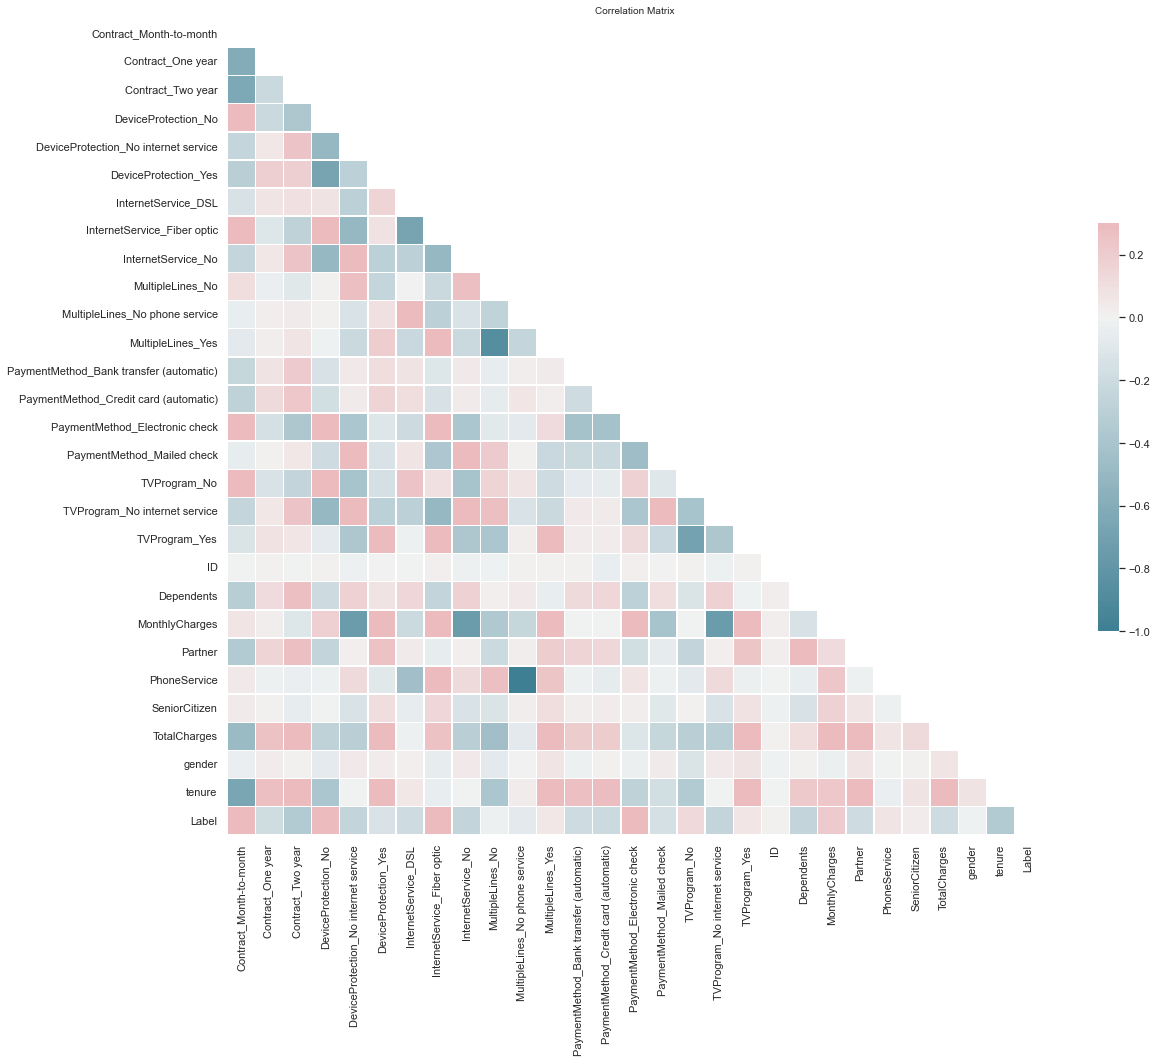

In [19]:
# 生成correlation matrix查看关联
# 设置Seaborn绘图的风格为白色背景
sns.set(style="white")

# 计算训练数据集train中各个特征之间的相关性，生成相关系数矩阵
corr = train.corr()
# print(corr)
# print(corr['Label'])

# 创建一个上三角形掩码矩阵，将相关系数矩阵中的下三角部分屏蔽，以便在热力图中只显示上三角形
mask = np.triu(np.ones_like(corr, dtype=np.bool))


# 创建一个画布和子图对象，设置图形的大小
f, ax = plt.subplots(figsize=(20, 15))

# 定义一个调色板，用于热力图的颜色映射。diverging_palette()函数生成一种从浅色到深色的调色板。
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# 设置图形的标题为"Correlation Matrix"，字体大小为18
plt.title('Correlation Matrix', fontsize=10)

# 使用Seaborn的heatmap()函数绘制热力图。传入的参数包括相关系数矩阵corr、掩码矩阵mask、调色板cmap以及其他一些图形设置。
# annot=True参数将在每个单元格中显示相关系数的数值。
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.show()

In [20]:
# 筛选与Label相关性不强的信息并删除
dropcol = [col for col in train.columns if abs(corr['Label'][col]) < 0.1]
dropcol

['MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'TVProgram_Yes',
 'ID',
 'PhoneService',
 'SeniorCitizen',
 'gender']

In [21]:
# 数据降维
train.drop(dropcol, axis = 1,inplace = True)
test.drop(dropcol, axis = 1, inplace = True)

In [22]:
train.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,TVProgram_No,TVProgram_No internet service,Dependents,MonthlyCharges,Partner,TotalCharges,tenure,Label
0,0,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,24.150000,1,1505.900000,60,0
1,1,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,76.142284,0,946.581518,12,1
2,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,1,26.200000,1,1077.500000,40,0
3,0,0,1,0,1,0,0,0,1,1,...,0,0,0,1,1,24.650000,1,1138.800000,45,0
4,1,0,0,0,1,0,0,0,1,0,...,0,1,0,1,1,19.150000,1,477.600000,25,0


## 4. 模型训练

In [23]:
# 划分训练集和验证集
X = train.drop('Label', axis=1)
y = train['Label']

In [24]:
# 检查Label比例
num_yes = train.Label.sum()
print(num_yes)
num_no = train.shape[0] - num_yes
print(num_no)

1947
3280


In [25]:
# 数据集不平衡，后续采用StratifiedKFold分层采样
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [26]:
# 构建模型
def model_select(X_train, y_train, clf, clf_name, parameters, kfold):
    pipeline = Pipeline([('scaler', MinMaxScaler()), (clf_name, clf)])
    # 数据不平衡，采用StratifiedKFold分层采样
    folder = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)

    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=parameters,
                               cv=folder,
                               scoring='accuracy')
    gs = grid_search.fit(X_train, y_train)
    print('最优参数{},最优分数{}'.format(gs.best_params_, gs.best_score_))
    return gs

In [28]:
# Decision Tree
no_folds = 10
dt = DecisionTreeClassifier(random_state=1)
dt_parameters = {'dt__max_depth': [4, 5, 6, 7, 9]}
dt_model = model_select(X_train, y_train, dt, 'dt', dt_parameters, no_folds)

最优参数{'dt__max_depth': 5},最优分数0.7701522193420196


In [29]:
y_pred = dt_model.predict(X_valid)
print(accuracy_score(y_valid, y_pred))

0.7753346080305927


## 5. 预测结果

In [30]:
final_DF = pd.DataFrame()
get_ID = pd.read_csv('test_noLabel.csv')
final_DF['ID'] = get_ID['ID']
final_DF['Label'] = pd.Series(y_pred).map({1:'Yes',0:'No'})

Name = 'predict.csv'
final_DF.to_csv(Name,index=True)

In [43]:
predict = pd.read_csv('predict.csv')
predict.head()

,Unnamed: 0,ID,Label
0,0,5227,No
1,1,5228,No
2,2,5229,Yes
3,3,5230,No
4,4,5231,No


## 6. 预测结果分析

In [49]:
# 对上述结果进行分析说明
predict['Label'].value_counts()

No     612
Yes    434
Name: Label, dtype: int64

In [53]:
# 计算客户化流失率
churn_rate = 434 / 1046
churn_rate

0.4149139579349904